
# 10. 고전 제어 문제 (Classic Control RL Problems)

이번 챕터에서는 OpenAI Gymnasium의 대표적인 고전 제어 환경인 **Mountain Car**와 **CartPole** 문제를 해결해 본다.

이 환경들의 가장 큰 특징은 **상태(State)가 연속적인 실수 값**으로 주어진다는 것이다. 예를 들어 자동차의 위치는 1, 2, 3처럼 딱 떨어지지 않고 1.253... 처럼 연속적이다. 테이블 기반의 Q-Learning을 적용하기 위해서는 이 연속적인 값을 적절한 구간(Bucket)으로 나누어 이산적인 상태로 변환하는 과정이 필요하다.

### 0. 라이브러리 설정

최신 버전인 `gymnasium`을 사용하며, 수학적 계산을 위한 라이브러리들을 불러온다.

In [6]:
%pip install -q "gymnasium[classic_control]"

Note: you may need to restart the kernel to use updated packages.


In [7]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython import display

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

---

## 1. Mountain Car (산악 자동차)

**Mountain Car**는 계곡 사이에 있는 자동차를 언덕 위의 깃발 위치까지 올리는 문제다. 자동차의 엔진 힘이 약해서 한 번에 올라갈 수 없으므로, 반동을 이용해 앞뒤로 왔다 갔다 하며 탄력을 받아야 한다.

### 1.1 환경 설정 및 분석

* **상태(State):** 자동차의 위치(Position), 속도(Velocity) (2차원)
* **행동(Action):** 왼쪽 가속(0), 정지(1), 오른쪽 가속(2) (3가지)
* **보상(Reward):** 목표에 도달할 때까지 매 스텝 -1의 보상을 받는다. 즉, 최대한 빨리 도달하는 것이 목표다.

In [8]:
# 환경 생성 (시각화 모드 설정)
env = gym.make('MountainCar-v0', render_mode='rgb_array')

print("상태 공간(State Space):", env.observation_space)
print("  - Low:", env.observation_space.low)
print("  - High:", env.observation_space.high)
print("행동 공간(Action Space):", env.action_space)

# 초기화 테스트
state, _ = env.reset()
print("초기 상태:", state)

상태 공간(State Space): Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
  - Low: [-1.2  -0.07]
  - High: [0.6  0.07]
행동 공간(Action Space): Discrete(3)
초기 상태: [-0.5183542  0.       ]


### 1.2 상태 이산화 (Discretization)

연속적인 위치와 속도 값을 격자(Grid) 형태로 나눈다. 예를 들어 위치와 속도를 각각 20개의 구간으로 나누면 총 개의 상태가 생긴다.

In [9]:
# 1. 상태를 이산화할 버킷(구간)의 개수 설정
n_buckets = (20, 20)  # 위치 20개, 속도 20개 구간

# 2. 각 차원의 범위(Range) 계산
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
# 속도 범위가 너무 크거나 작을 수 있으므로 적절히 조정할 수도 있으나, 여기선 기본값 사용
# MountainCar의 속도 범위는 보통 [-0.07, 0.07] 정도임

def discretize(state, bounds, n_buckets):
    """
    연속적인 상태(state)를 이산적인 인덱스(tuple)로 변환한다.
    """
    discretized = []
    for i in range(len(state)):
        # 현재 값의 비율 계산 (0.0 ~ 1.0)
        scaling = (state[i] - bounds[i][0]) / (bounds[i][1] - bounds[i][0])

        # 버킷 개수에 맞게 인덱스로 변환
        new_obs = int(round((n_buckets[i] - 1) * scaling))

        # 인덱스가 범위를 벗어나지 않도록 클리핑
        new_obs = min(n_buckets[i] - 1, max(0, new_obs))
        discretized.append(new_obs)

    return tuple(discretized)

# 테스트
test_state = np.array([-0.5, 0.0]) # 대략 중간 위치, 정지 상태
discrete_state = discretize(test_state, state_bounds, n_buckets)
print(f"연속 상태 {test_state} -> 이산 상태 {discrete_state}")

연속 상태 [-0.5  0. ] -> 이산 상태 (7, 10)


### 1.3 Q-Learning 학습

이산화된 상태를 사용하여 표준 Q-Learning 알고리즘을 적용한다.

In [10]:
# Q-테이블 초기화 (20x20x3)
q_table = np.zeros(n_buckets + (env.action_space.n,))

# 하이퍼파라미터 설정
EPISODES = 5000       # 총 에피소드 수
ALPHA = 0.1           # 학습률
GAMMA = 0.99          # 할인율
EPSILON = 1.0         # 초기 탐험 확률
MIN_EPSILON = 0.01    # 최소 탐험 확률
DECAY_RATE = 0.001    # 탐험 감소율 (Exponential Decay) or Linear

# 시각화를 위한 함수
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("Episode: %d %s" % (step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

# 학습 루프
scores = []

for episode in range(EPISODES):
    # 환경 초기화 및 상태 이산화
    current_state_continuous, _ = env.reset()
    current_state = discretize(current_state_continuous, state_bounds, n_buckets)

    done = False
    score = 0

    while not done:
        # 1. 행동 선택 (Epsilon-Greedy)
        if np.random.random() < EPSILON:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[current_state])

        # 2. 행동 수행
        next_state_continuous, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_state = discretize(next_state_continuous, state_bounds, n_buckets)

        # 3. Q-Learning 업데이트
        # Q(s,a) = Q(s,a) + alpha * (r + gamma * max(Q(s',:)) - Q(s,a))
        best_next_q = np.max(q_table[next_state])
        current_q = q_table[current_state + (action,)]

        new_q = current_q + ALPHA * (reward + GAMMA * best_next_q - current_q)
        q_table[current_state + (action,)] = new_q

        # 상태 갱신
        current_state = next_state
        score += reward

    scores.append(score)

    # 엡실론 감쇠
    EPSILON = max(MIN_EPSILON, EPSILON * np.exp(-DECAY_RATE))

    if episode % 500 == 0:
        print(f"Episode: {episode}, Score: {score}, Epsilon: {EPSILON:.2f}")

print("Mountain Car 학습 완료!")
env.close()

Episode: 0, Score: -200.0, Epsilon: 1.00
Episode: 500, Score: -200.0, Epsilon: 0.61
Episode: 1000, Score: -200.0, Epsilon: 0.37
Episode: 1500, Score: -200.0, Epsilon: 0.22
Episode: 2000, Score: -200.0, Epsilon: 0.14
Episode: 2500, Score: -200.0, Epsilon: 0.08
Episode: 3000, Score: -189.0, Epsilon: 0.05
Episode: 3500, Score: -192.0, Epsilon: 0.03
Episode: 4000, Score: -148.0, Epsilon: 0.02
Episode: 4500, Score: -176.0, Epsilon: 0.01
Mountain Car 학습 완료!


### 1.4 결과 확인

학습된 Q-테이블을 이용해 에이전트가 언덕을 잘 올라가는지 테스트한다.

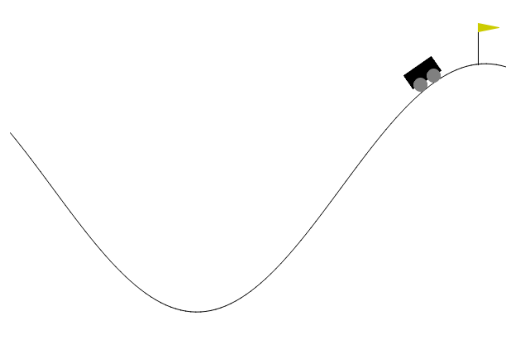

In [11]:
# 테스트 실행
env = gym.make('MountainCar-v0', render_mode='rgb_array')
state_continuous, _ = env.reset()
state = discretize(state_continuous, state_bounds, n_buckets)
done = False

img = plt.imshow(env.render())
plt.axis('off')

while not done:
    # 학습된 정책(Greedy) 사용
    action = np.argmax(q_table[state])

    next_state_continuous, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    state = discretize(next_state_continuous, state_bounds, n_buckets)

    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

env.close()

---

## 2. CartPole (카트폴)

**CartPole**은 카트 위에 세워진 막대기가 쓰러지지 않도록 카트를 좌우로 움직여 균형을 잡는 문제다.

### 2.1 환경 설정 및 분석

* **상태(State):** 카트 위치, 카트 속도, 막대 각도, 막대 각속도 (4차원)
* **행동(Action):** 왼쪽 밀기(0), 오른쪽 밀기(1)
* **보상(Reward):** 막대가 서 있는 매 순간마다 +1점. (오래 버틸수록 점수가 높다)

주의할 점은 속도와 각속도의 범위가 무한대()일 수 있다는 점이다. 이산화를 위해 적절한 범위로 제한(Clipping)해 줄 필요가 있다.

In [12]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

# 상태 범위 확인 (속도는 inf로 나옴)
print("Observation Space High:", env.observation_space.high)
print("Observation Space Low:", env.observation_space.low)

# 이산화를 위한 임의의 경계 설정
# (카트 위치, 카트 속도, 막대 각도, 막대 각속도)
# 속도값은 실제로는 무한대지만, 유의미한 범위 내로 자른다.
# 각도는 라디안 단위임 (약 24도 = 0.418 rad, 약 50도 = 0.87 rad 등)
upper_bounds = [2.4, 0.5, 0.418, 0.87] # [m, m/s, rad, rad/s]
lower_bounds = [-2.4, -0.5, -0.418, -0.87]

cartpole_bounds = list(zip(lower_bounds, upper_bounds))

Observation Space High: [4.8               inf 0.41887903        inf]
Observation Space Low: [-4.8               -inf -0.41887903        -inf]


### 2.2 학습 코드 (Q-Learning)

Mountain Car와 동일한 로직을 사용하되, 4차원 상태 공간을 다룬다. 차원이 늘어날수록 상태의 수(경우의 수)가 기하급수적으로 늘어나므로(Curse of Dimensionality), 버킷의 크기를 적절히 조절해야 한다.

In [13]:
# 4차원 버킷 설정: 위치(1), 속도(1), 각도(6), 각속도(12)
# 중요하지 않은 차원은 버킷 수를 줄여서 테이블 크기를 최적화함
n_buckets = (1, 1, 6, 12)

# Q-테이블 초기화 (1x1x6x12 x 2)
q_table = np.zeros(n_buckets + (env.action_space.n,))

def discretize_cartpole(state, bounds, n_buckets):
    discretized = []
    for i in range(len(state)):
        # 범위 밖의 값은 클리핑
        val = max(bounds[i][0], min(state[i], bounds[i][1]))

        scaling = (val - bounds[i][0]) / (bounds[i][1] - bounds[i][0])
        new_obs = int(round((n_buckets[i] - 1) * scaling))
        new_obs = min(n_buckets[i] - 1, max(0, new_obs))
        discretized.append(new_obs)
    return tuple(discretized)

# 하이퍼파라미터
EPISODES = 1000
ALPHA = 0.1
GAMMA = 0.99
EPSILON = 1.0
DECAY_RATE = 0.005 # 빠르게 감소

scores = []

for episode in range(EPISODES):
    current_state_continuous, _ = env.reset()
    current_state = discretize_cartpole(current_state_continuous, cartpole_bounds, n_buckets)

    done = False
    score = 0

    while not done:
        if np.random.random() < EPSILON:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[current_state])

        next_state_continuous, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        next_state = discretize_cartpole(next_state_continuous, cartpole_bounds, n_buckets)

        best_next_q = np.max(q_table[next_state])
        current_q = q_table[current_state + (action,)]

        new_q = current_q + ALPHA * (reward + GAMMA * best_next_q - current_q)
        q_table[current_state + (action,)] = new_q

        current_state = next_state
        score += reward

    scores.append(score)
    EPSILON = max(0.01, EPSILON * np.exp(-DECAY_RATE))

    if episode % 100 == 0:
        print(f"Episode: {episode}, Score: {score}, Epsilon: {EPSILON:.2f}")

print("CartPole 학습 완료!")
env.close()

Episode: 0, Score: 13.0, Epsilon: 1.00
Episode: 100, Score: 34.0, Epsilon: 0.60
Episode: 200, Score: 70.0, Epsilon: 0.37
Episode: 300, Score: 102.0, Epsilon: 0.22
Episode: 400, Score: 500.0, Epsilon: 0.13
Episode: 500, Score: 500.0, Epsilon: 0.08
Episode: 600, Score: 500.0, Epsilon: 0.05
Episode: 700, Score: 500.0, Epsilon: 0.03
Episode: 800, Score: 500.0, Epsilon: 0.02
Episode: 900, Score: 500.0, Epsilon: 0.01
CartPole 학습 완료!


### 2.3 학습 결과 시각화 (점수 변화)

CartPole은 학습이 잘 되면 점수(버티는 시간)가 급격히 상승한다.

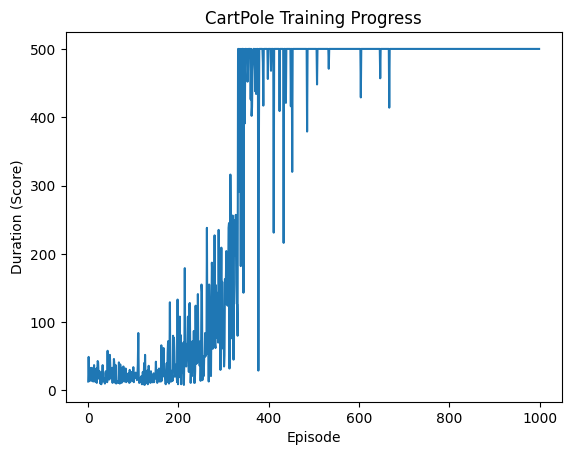

In [14]:
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Duration (Score)')
plt.title('CartPole Training Progress')
plt.show()

### 요약

연속적인 상태 공간을 가진 문제도 **이산화(Discretization)**를 통해 기본적인 Q-Learning 알고리즘을 적용할 수 있다. 하지만 상태의 차원이 높아질수록 테이블의 크기가 너무 커져 학습이 어려워지는 **차원의 저주** 문제가 발생한다. 이를 해결하기 위해 다음 단계에서는 신경망을 사용하여 가치 함수를 근사하는 **DQN(Deep Q-Network)** 방법을 사용하게 된다.